In [1]:
import sys  ###kfheader
sys.path.append('../scripts/')
from robot import *
from scipy.stats import multivariate_normal #追加（多変量ガウス分布のモジュール。既出）
from matplotlib.patches import Ellipse           #  追加

In [2]:
def sigma_ellipse(p, cov, n): ###kf2threesigma
    eig_vals, eig_vec = np.linalg.eig(cov)
    ang = math.atan2(eig_vec[:,0][1], eig_vec[:,0][0])/math.pi*180
    return Ellipse(p, width=n*math.sqrt(eig_vals[0]),height=n*math.sqrt(eig_vals[1]), angle=ang, fill=False, color="blue", alpha=0.5)

In [3]:
class KalmanFilter: ###kalmanfilter1
    def __init__(self, envmap, init_pose, motion_noise_stds={"nn":0.19, "no":0.001, "on":0.13, "oo":0.2}):
        self.belief = multivariate_normal(mean=np.array([0.0, 0.0, math.pi/4]), cov=np.diag([0.1, 0.2, 0.01]))
        
    def draw(self, ax, elems):
        ###xy平面上の誤差の10シグマ範囲###
        e = sigma_ellipse(self.belief.mean[0:2], self.belief.cov[0:2, 0:2], 3)
        elems.append(ax.add_patch(e))

        ###θ方向の誤差の3シグマ範囲###
        x, y, c = self.belief.mean
        sigma3 = math.sqrt(self.belief.cov[2, 2])*3
        xs = [x + math.cos(c-sigma3), x, x + math.cos(c+sigma3)]
        ys = [y + math.sin(c-sigma3), y, y + math.sin(c+sigma3)]
        elems += ax.plot(xs, ys, color="blue", alpha=0.5)

In [4]:
class KfAgent(Agent): ###kfagent2（下のセルも）
    def __init__(self, time_interval, nu, omega, kf):
        super().__init__(nu, omega)
        self.kf = kf                                            #書き換え
        self.time_interval = time_interval
        
    def draw(self, ax, elems): #追加
        self.kf.draw(ax, elems)

<IPython.core.display.Javascript object>


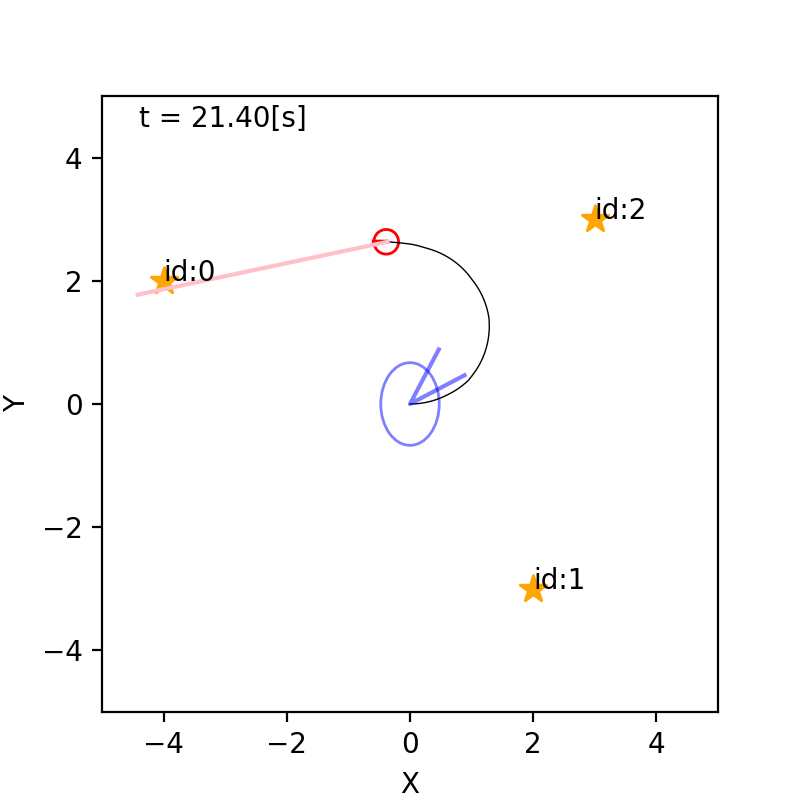

In [5]:
if __name__ == '__main__': 
    time_interval = 0.1
    world = World(30, time_interval, debug=False) 

    ### 地図を生成して3つランドマークを追加 ###
    m = Map()                                  
    m.append_landmark(Landmark(-4,2))
    m.append_landmark(Landmark(2,-3))
    m.append_landmark(Landmark(3,3))
    world.append(m)          

    ### ロボットを作る ###
    initial_pose = np.array([0, 0, 0]).T
    kf = KalmanFilter(m, initial_pose) #カルマンフィルタを作る
    circling = KfAgent(time_interval, 0.2, 10.0/180*math.pi, kf)    #Noneをkfに
    r = Robot(initial_pose, sensor=Camera(m), agent=circling, color="red")
    world.append(r)

    world.draw()